## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR 

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


In [40]:
import pandas as pd
import numpy as np
import requests

series = ["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]

START = "2022-01-01"
END   = "2025-12-31"

bcrp_url = (
    "https://estadisticas.bcrp.gob.pe/estadisticas/series/api/"+ "-".join(series)+ f"/json/{START}/{END}")

try:
    r = requests.get(bcrp_url, timeout=30)
    r.raise_for_status()
    bcrp_obj = r.json()
except Exception as e:
    bcrp_obj = {"periods": []}
    print("BCRP request failed:", type(e).__name__, str(e))

periods = bcrp_obj.get("periods", [])

rows = []
for p in periods:
    name = p.get("name")
    vals = p.get("values", [])

    if isinstance(vals, str):
        vals = [vals]
    if name is None or not isinstance(vals, list):
        continue

    for s, v in zip(series, vals):
        rows.append([name, s, v])


2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


In [41]:
df = pd.DataFrame(rows, columns=["date", "series", "value"])
df["value"] = pd.to_numeric(df["value"], errors="coerce")

month = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr",
    "May": "May", "Jun": "Jun", "Jul": "Jul", "Ago": "Aug",
    "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov",
    "Dic": "Dec"
}

df["date"] = df["date"].replace(month, regex=True)
df["date"] = pd.to_datetime(df["date"], format="%d.%b.%y", errors="coerce")

df.head()

,date,series,value
0,2022-01-03,PD04637PD,3.983667
1,2022-01-03,PD04639PD,3.987000
2,2022-01-03,PD04704XD,439.621725
3,2022-01-03,PD04701XD,1820.100000
4,2022-01-04,PD04637PD,3.959500


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


In [42]:
# Map series codes to notebook-style names
series_map = {
    "PD04637PD": "fx_interbank",
    "PD04639PD": "fx_sbs",
    "PD04704XD": "gold",
    "PD04701XD": "copper"
}

# Replace series codes by names
peru_w = df.replace({"series": series_map})

# Pivot to wide format and sort by date
peru_w = (peru_w.pivot(index="date", columns="series", values="value").sort_values("date"))
peru_w.head()

series,copper,fx_interbank,fx_sbs,gold
date,,,,
2022-01-03,1820.10,3.983667,3.987,439.621725
2022-01-04,1811.40,3.959500,3.963,438.170229
2022-01-05,1826.25,3.952000,3.953,443.522619
2022-01-06,1789.35,3.967167,3.967,433.861102
2022-01-07,1792.60,3.945167,3.948,436.129064


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


In [43]:
import yfinance as yf

# Download close prices
tickers = ["SPY", "TLT", "GLD"]
usa_raw = yf.download(
    tickers,
    start=START,
    end=END
)["Close"]

# Convert to tidy format
usa_tidy = (usa_raw.reset_index().melt(id_vars="Date", var_name="ticker", value_name="close").rename(columns={"Date": "date"}))
usa_tidy.head()

C:\Users\User\AppData\Local\Temp\ipykernel_8872\3727944694.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usa_raw = yf.download(
[*********************100%***********************]  3 of 3 completed


,date,ticker,close
0,2022-01-03,GLD,168.330002
1,2022-01-04,GLD,169.570007
2,2022-01-05,GLD,169.059998
3,2022-01-06,GLD,166.990005
4,2022-01-07,GLD,167.750000


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


In [44]:
# Sort by ticker and date 
usa_tidy = usa_tidy.sort_values(['ticker', 'date'])

# Compute daily returns by ticker
usa_tidy['ret'] = usa_tidy.groupby('ticker')['close'].pct_change()

# Replace inf values with NaN
usa_tidy['ret'] = usa_tidy['ret'].replace([np.inf, -np.inf], np.nan)

# Check that no inf values remain
np.isinf(usa_tidy['ret']).any()

np.False_

6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  


8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  


9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  


10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  


11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  


C:\Users\User\AppData\Local\Temp\ipykernel_8872\579748543.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  peru_fx['FX_change'] = peru_fx['fx_interbank'].pct_change()


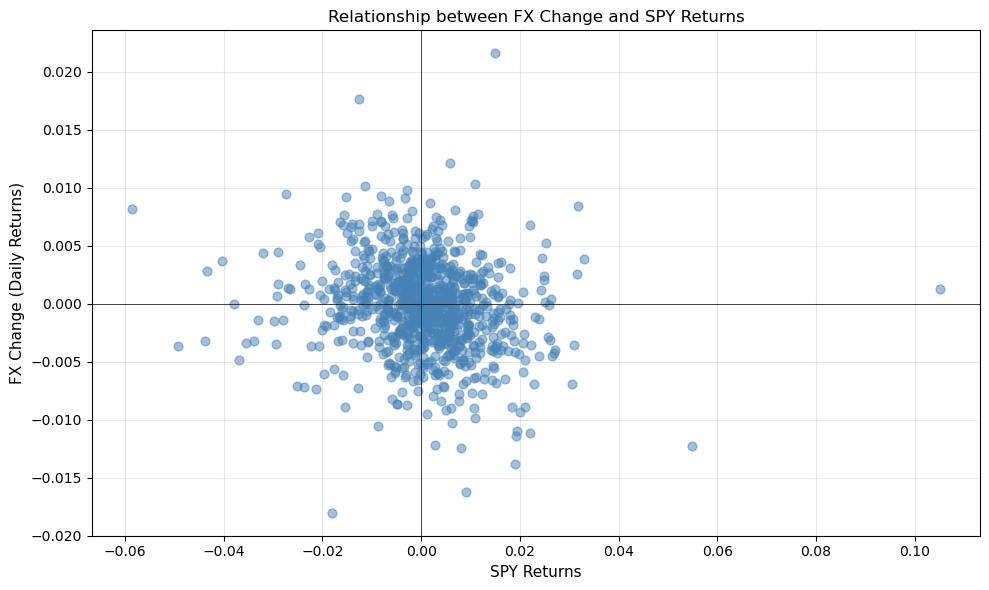

In [45]:
import matplotlib.pyplot as plt

# Step 1: Create FX_change from Peru data (daily returns of fx_interbank)
peru_fx = peru_w[['fx_interbank']].copy()
peru_fx['FX_change'] = peru_fx['fx_interbank'].pct_change()

# Step 2: Extract SPY returns from USA data
spy_data = usa_tidy[usa_tidy['ticker'] == 'SPY'][['date', 'ret']].copy()
spy_data.columns = ['date', 'SPY_ret']
spy_data.set_index('date', inplace=True)

# Step 3: Merge FX_change and SPY_ret by date
relationship_data = peru_fx.join(spy_data, how='inner')
relationship_data = relationship_data.dropna()

# Step 4: Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(relationship_data['SPY_ret'], relationship_data['FX_change'], alpha=0.5, s=40, color='steelblue')
plt.xlabel('SPY Returns', fontsize=11)
plt.ylabel('FX Change (Daily Returns)', fontsize=11)
plt.title('Relationship between FX Change and SPY Returns', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()


12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign.  


In [46]:
# Step 1: Calculate correlation between FX_change and SPY_ret
# Usamos relationship_data que ya tiene ambas variables sin valores NaN
correlation = relationship_data['FX_change'].corr(relationship_data['SPY_ret'])

# Step 2: Display the correlation coefficient
print(f"Correlation between FX_change and SPY_ret: {correlation:.4f}")

print(f"The negative correlation ({correlation:.4f}) indicates that when SPY returns increase,")
print("the Peruvian Sol tends to depreciate (FX_change decreases).")

Correlation between FX_change and SPY_ret: -0.1726
The negative correlation (-0.1726) indicates that when SPY returns increase,
the Peruvian Sol tends to depreciate (FX_change decreases).


13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  


In [47]:
# Step 1: Prepare data for regression (using relationship_data from earlier)
X = relationship_data['SPY_ret'].values  # Independent variable
Y = relationship_data['FX_change'].values  # Dependent variable

# Step 2: Calculate regression coefficients using OLS formulas
# Beta (slope) = Cov(X,Y) / Var(X)
# Alpha (intercept) = mean(Y) - Beta * mean(X)
mean_X = X.mean()
mean_Y = Y.mean()

# Calculate beta (slope)
covariance = ((X - mean_X) * (Y - mean_Y)).sum()
variance_X = ((X - mean_X) ** 2).sum()
beta = covariance / variance_X

# Step 3: Display results
print("Simple Linear Regression: FX_change ~ SPY_ret")
print(f"Slope (β):{beta:.6f}")

# Step 4: Interpretation
print("\nInterpretation:")
print(f"For every 1% increase in SPY returns, the Peruvian Sol FX rate")
print(f"changes by {beta:.6f}%, on average.")

Simple Linear Regression: FX_change ~ SPY_ret
Slope (β):-0.058661

Interpretation:
For every 1% increase in SPY returns, the Peruvian Sol FX rate
changes by -0.058661%, on average.


14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering.  


In [48]:
# Table 1: Selection by position (.iloc)
print("Selection by POSITION (.iloc):")
print(relationship_data.iloc[0:5])

# Table 2: Conditional filtering
print("\nSelection by CONDITION (SPY_ret > 0):")
print(relationship_data[relationship_data['SPY_ret'] > 0].head())

# Comment
print("\n.iloc selects by row position, conditional filtering selects by value criteria.")

Selection by POSITION (.iloc):
            fx_interbank  FX_change   SPY_ret
date                                         
2022-01-04      3.959500  -0.006066 -0.000335
2022-01-05      3.952000  -0.001894 -0.019202
2022-01-06      3.967167   0.003838 -0.000939
2022-01-07      3.945167  -0.005546 -0.003954
2022-01-10      3.927667  -0.004436 -0.001244

Selection by CONDITION (SPY_ret > 0):
            fx_interbank  FX_change   SPY_ret
date                                         
2022-01-11      3.916333  -0.002886  0.009108
2022-01-12      3.892333  -0.006128  0.002703
2022-01-14      3.870333  -0.006290  0.000409
2022-01-24      3.839000   0.004579  0.004247
2022-01-28      3.844000   0.002042  0.024836

.iloc selects by row position, conditional filtering selects by value criteria.


15. Create missing data on purpose in one series and apply imputation (as in the notebook).  


In [49]:
# Step 1: Create a copy and introduce missing values on purpose
data_with_missing = relationship_data.copy()
data_with_missing.loc[data_with_missing.index[10:20], 'SPY_ret'] = np.nan

# Step 2: Apply mean imputation
data_imputed_mean = data_with_missing.fillna(data_with_missing.mean())

print("\nAfter mean imputation (rows 9-21):")
print(data_imputed_mean.iloc[9:21])


After mean imputation (rows 9-21):
            fx_interbank  FX_change   SPY_ret
date                                         
2022-01-18      3.852833   0.001343 -0.017710
2022-01-19      3.862500   0.002509  0.000428
2022-01-20      3.844667  -0.004617  0.000428
2022-01-21      3.821500  -0.006026  0.000428
2022-01-24      3.839000   0.004579  0.000428
2022-01-25      3.847500   0.002214  0.000428
2022-01-26      3.840333  -0.001863  0.000428
2022-01-27      3.836167  -0.001085  0.000428
2022-01-28      3.844000   0.002042  0.000428
2022-01-31      3.840333  -0.000954  0.000428
2022-02-01      3.871333   0.008072  0.000428
2022-02-02      3.852000  -0.004994  0.009714


16. Standardize a variable (z-score) and plot **before vs after**.  


17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  


18. Save one figure into `/figures` using `savefig` and verify the file exists.  


19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  


20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.


# Lecture 4
### Peru (BCRPData API)
- **FX**: Interbank USD/PEN (buy) vs SBS banking system USD/PEN (buy)
- **Commodities**: Gold and Copper reference prices (daily series published by BCRP)

### USA (Yahoo Finance via `yfinance`)
- **Market**: SPY (US equities), TLT (US long bonds), GLD (gold ETF)

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)

In [51]:
from __future__ import annotations

from pathlib import Path
import hashlib
import re
from io import StringIO

import numpy as np
import pandas as pd

# Configuration


CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)

# Cache utilities (parquet -> csv fallback)

def _hash_key(*parts: object) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _cache_paths(prefix: str, key: str) -> tuple[Path, Path]:
    p_parquet = CACHE_DIR / f"{prefix}_{key}.parquet"
    p_csv = CACHE_DIR / f"{prefix}_{key}.csv"
    return p_parquet, p_csv

def _read_cache_df(prefix: str, key: str) -> pd.DataFrame | None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    if p_parquet.exists():
        try:
            return pd.read_parquet(p_parquet)
        except Exception:
            pass
    if p_csv.exists():
        try:
            return pd.read_csv(p_csv)
        except Exception:
            pass
    return None

def _write_cache_df(df: pd.DataFrame, prefix: str, key: str) -> None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    try:
        df.to_parquet(p_parquet, index=False)
        return
    except Exception:
        pass
    try:
        df.to_csv(p_csv, index=False)
    except Exception:
        # If caching fails, ignore silently (no exceptions)
        return

# HTTP helpers

def http_get_text(url: str, timeout: int = 30, headers: dict | None = None) -> str:
    """
    Returns response text. Raises inside, but callers wrap in try/except (no exceptions to user).
    """
    import requests

    h = {
        "User-Agent": "Mozilla/5.0 (compatible; FinanceCourse/1.0)",
        "Accept": "*/*",
    }
    if headers:
        h.update(headers)

    r = requests.get(url, timeout=timeout, headers=h)
    r.raise_for_status()
    return r.text
# Numeric + returns helpers
def parse_number(x) -> float:
    """
    Robust number parser:
      - '3,367' -> 3.367 (comma decimal)
      - '1,234.56' -> 1234.56 (comma thousands)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan

    if "," in s and "." in s:
        s = s.replace(",", "")
    elif "," in s and "." not in s:
        s = s.replace(",", ".")

    try:
        return float(s)
    except Exception:
        return np.nan

def pct_change(s: pd.Series) -> pd.Series:
    x = pd.to_numeric(s, errors="coerce")
    return x.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)
# BCRP parsing

_SP2EN = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec",
}

def _clean_bcrp_payload(txt: str) -> str:
    """
    BCRP sometimes returns "CSV" wrapped as HTML with <br> line breaks.
    Normalize to plain text with real newlines.
    """
    x = txt.replace("\r\n", "\n").replace("\r", "\n")
    x = x.replace("<br/>", "\n").replace("<br />", "\n").replace("<br>", "\n")
    x = re.sub(r"</?pre[^>]*>", "", x, flags=re.IGNORECASE)
    return x.strip()

def _detect_sep(header_line: str) -> str:
    return ";" if header_line.count(";") > header_line.count(",") else ","

def _parse_bcrp_date(s: pd.Series) -> pd.Series:
    """
    Parses common BCRP date formats:
      - Daily: 2022-01-03, 03Jan22, 03Ene22
      - Monthly: Jan22, Ene22, 2022-1, 2022-01
      - Yearly: 2022
    """
    x = s.astype(str).str.strip()
    x = x.str.replace(".", "", regex=False)

    y = x
    for k, v in _SP2EN.items():
        y = y.str.replace(k, v, regex=False)

    dt = pd.to_datetime(y, format="%Y-%m-%d", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%d%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y-%m", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], errors="coerce")

    return dt


def bcrp_series_csv(
    series_codes: list[str],
    start: str,
    end: str,
    lang: str = "ing",
) -> pd.DataFrame:
    """
    BCRPData API (CSV):
      https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[codes]/csv/[start]/[end]/[lang]

    Returns LONG DataFrame:
      date, series_name, value

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    codes = "-".join(series_codes)
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}"

    key = _hash_key("bcrp", url)
    cached = _read_cache_df("bcrp", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        txt = http_get_text(url, timeout=30)
        txt = _clean_bcrp_payload(txt)

        lines = [ln for ln in txt.split("\n") if ln.strip() != ""]
        if len(lines) < 2:
            print("[BCRP] Endpoint returned no usable rows. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        sep = _detect_sep(lines[0])
        df = pd.read_csv(StringIO("\n".join(lines)), sep=sep)

        if df.shape[0] == 0 or df.shape[1] < 2:
            print("[BCRP] Returned an empty table. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        date_col = df.columns[0]
        value_cols = list(df.columns[1:])

        out = df.melt(
            id_vars=[date_col],
            value_vars=value_cols,
            var_name="series_name",
            value_name="value_raw",
        ).rename(columns={date_col: "date"})

        out["date"] = _parse_bcrp_date(out["date"])
        out["value"] = out["value_raw"].map(parse_number)

        out = out.drop(columns=["value_raw"])
        out = out.dropna(subset=["date"]).sort_values(["series_name", "date"]).reset_index(drop=True)

        _write_cache_df(out, "bcrp", key)
        return out

    except Exception as e:
        print(f"[BCRP] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "series_name", "value"])
# Yahoo Finance (yfinance)

def yfinance_download(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """
    Yahoo Finance via yfinance.
    Returns LONG DataFrame:
      date, ticker, close, volume, ret

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    try:
        import yfinance as yf
    except Exception:
        print("[yfinance] yfinance not installed/importable. Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

    key = _hash_key("yfinance", " ".join(tickers), start, end)
    cached = _read_cache_df("yf", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        data = yf.download(tickers=tickers, start=start, end=end, auto_adjust=False, progress=False)
        if data is None or data.shape[0] == 0:
            print("[yfinance] Returned no rows. Continuing...")
            return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

        frames = []
        if isinstance(data.columns, pd.MultiIndex):
            for t in tickers:
                if t not in data.columns.get_level_values(1):
                    continue
                sub = data.xs(t, axis=1, level=1).copy()
                sub = sub.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
                sub["ticker"] = t
                sub = sub.rename(columns={"Close": "close", "Volume": "volume"})
                frames.append(sub[["date", "ticker", "close", "volume"]])
            out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
        else:
            out = data.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
            out["ticker"] = tickers[0]
            out = out.rename(columns={"Close": "close", "Volume": "volume"})
            out = out[["date", "ticker", "close", "volume"]]

        out["date"] = pd.to_datetime(out["date"], errors="coerce")
        out["close"] = pd.to_numeric(out["close"], errors="coerce")
        out["volume"] = pd.to_numeric(out["volume"], errors="coerce")

        out = out.dropna(subset=["date", "close"]).sort_values(["ticker", "date"]).reset_index(drop=True)
        out["ret"] = out.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

        _write_cache_df(out, "yf", key)
        return out

    except Exception as e:
        print(f"[yfinance] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

## 0) Load real financial data

If an endpoint is temporarily unavailable, this notebook prints a short message and continues

In [52]:
START_D = "2022-01-01"
END_D   = "2025-12-18"

peru = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)

usa = yfinance_download(["SPY", "TLT", "GLD"], start=START_D, end=END_D)

print("Peru rows:", peru.shape[0], "| USA rows:", usa.shape[0])

# show in English (wide + renamed)
peru_wide = (
    peru.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
        .reset_index()
        .sort_values("date")
)
peru_wide.columns.name = None

rename_map = {}
for c in peru_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_sbs_buy"
    elif "oro" in cl or "gold" in cl:
        rename_map[c] = "gold_london"
    elif "cobre" in cl or "copper" in cl:
        rename_map[c] = "copper_london"

peru_wide = peru_wide.rename(columns=rename_map)
peru_wide.head()


Peru rows: 4136 | USA rows: 2982


,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


## 1) Quantities

### Exercise 1.1 — FX level comparison (Peru)

**Tasks**
1. Filter `peru` to the two FX series (Interbank buy and SBS buy).
2. Pivot to wide format (`date` as index).
3. Plot both FX levels in the same line chart.
4. Create `spread = sbs - interbank` and plot it in a separate figure.

In [53]:
# 1. Filter peru to the two FX series (Interbank buy and SBS buy)
peru_fx = peru_wide[['date', 'fx_interbank_buy', 'fx_sbs_buy']]
peru_fx.head()

,date,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,3.983667,3.987
1,2022-01-04,3.959500,3.963
2,2022-01-05,3.952000,3.953
3,2022-01-06,3.967167,3.967
4,2022-01-07,3.945167,3.948


In [54]:
# 2. Pivot to wide format (`date` as index)

# Set date as index (set_index) and sort chronologically (sort_idex)
peru_fx = (peru_fx.set_index('date').sort_index())
peru_fx.head()

,fx_interbank_buy,fx_sbs_buy
date,,
2022-01-03,3.983667,3.987
2022-01-04,3.959500,3.963
2022-01-05,3.952000,3.953
2022-01-06,3.967167,3.967
2022-01-07,3.945167,3.948


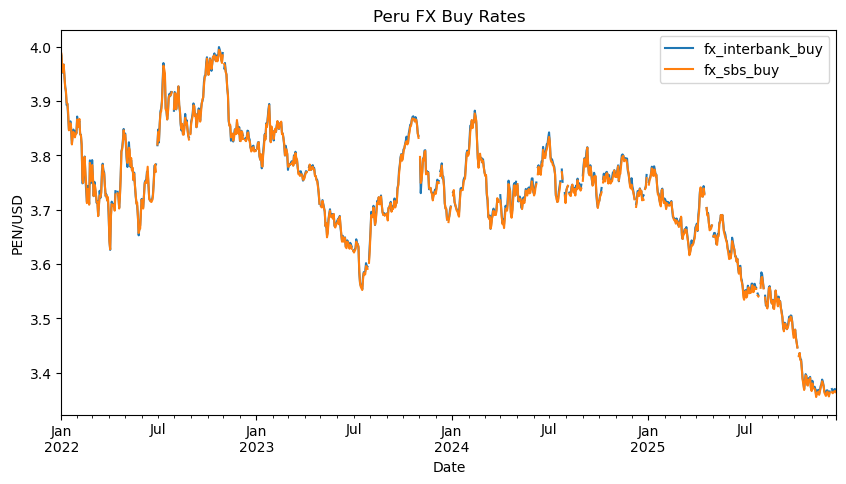

In [55]:
# 3. Plot both FX levels in the same line chart

# Plot FX series (.plot)
peru_fx.plot(figsize=(10, 5))

# Labels
plt.xlabel("Date")
plt.ylabel("PEN/USD")
plt.title("Peru FX Buy Rates")

plt.show()

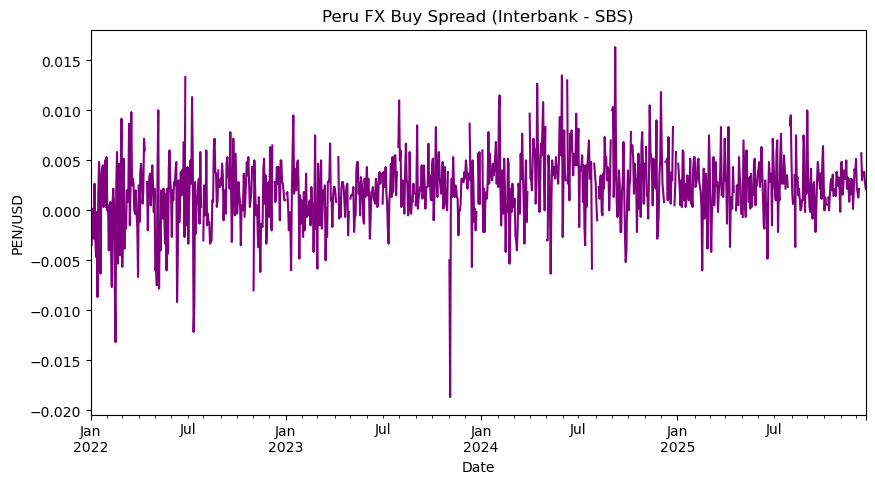

In [56]:
# 4. Create `spread = sbs - interbank` and plot it in a separate figure.

# Compute FX spread (Interbank - SBS)
peru_fx['spread'] = peru_fx['fx_interbank_buy'] - peru_fx['fx_sbs_buy']

# Plot spread (.plot)
peru_fx['spread'].plot(figsize=(10, 5),color="purple")

# Labels
plt.xlabel("Date")
plt.ylabel("PEN/USD")
plt.title("Peru FX Buy Spread (Interbank - SBS)")

plt.show()

## 2) Proportions

### Exercise 2.1 — Share of positive-return days (USA)

Define a positive day as `ret > 0`.

**Tasks**
1. For each ticker in `usa`, compute the share of days with `ret > 0`.
2. Plot a bar chart of these shares.
3. Add labels (percent format) and a title.

In [57]:
# 1. For each ticker in `usa`, compute the share of days with `ret > 0`

# Define positive return indicator
usa['positive'] = usa['ret'] > 0

# Compute share of positive days by ticker (groupby and mean)
positive_share = (usa.groupby('ticker')['positive'].mean())
positive_share


ticker
GLD    0.545272
SPY    0.535211
TLT    0.492958
Name: positive, dtype: float64

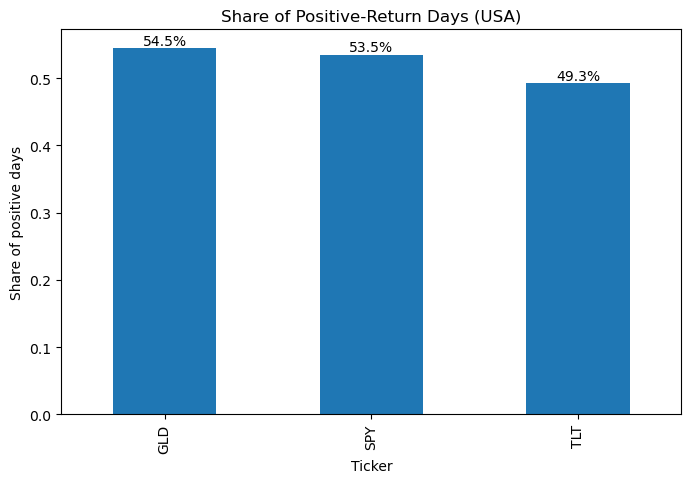

In [58]:
# 2–3. Plot a bar chart of positive-return shares

ax = positive_share.plot(kind='bar', figsize=(8, 5))

plt.xlabel("Ticker")
plt.ylabel("Share of positive days")
plt.title("Share of Positive-Return Days (USA)")

# Add percentage labels
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1%}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

plt.show()

## 3) Distributions

### Exercise 3.1 — Return distributions: Peru Gold vs US Gold ETF

**Goal:** compare distributions of a **Peru gold reference price** series vs the **US gold ETF (GLD)**.

**Tasks**
1. From `peru`, build a daily gold series and compute returns.
2. From `usa`, filter to GLD returns.
3. Plot two histograms (separate figures) with the same binning.
4. Optional: overlay KDE for each distribution.

In [59]:
# 1. From `peru`, build a daily gold series and compute returns

# Build daily Peru gold price series
peru_gold = peru_wide[['date', 'gold_london']].copy()

# Sort by date 
peru_gold = peru_gold.sort_values('date')

# Compute daily returns
peru_gold['ret'] = peru_gold['gold_london'].pct_change()
peru_gold.head()

,date,gold_london,ret
0,2022-01-03,1820.10,NaN
1,2022-01-04,1811.40,-0.004780
2,2022-01-05,1826.25,0.008198
3,2022-01-06,1789.35,-0.020205
4,2022-01-07,1792.60,0.001816


In [60]:
# 2. From `usa`, filter to GLD returns

# Filter GLD returns from USA data
usa_gld = usa[usa['ticker'] == 'GLD'][['date', 'ret']]

# Sort by date
usa_gld = usa_gld.sort_values('date')
usa_gld.head()

,date,ret
0,2022-01-03,NaN
1,2022-01-04,0.007367
2,2022-01-05,-0.003008
3,2022-01-06,-0.012244
4,2022-01-07,0.004551


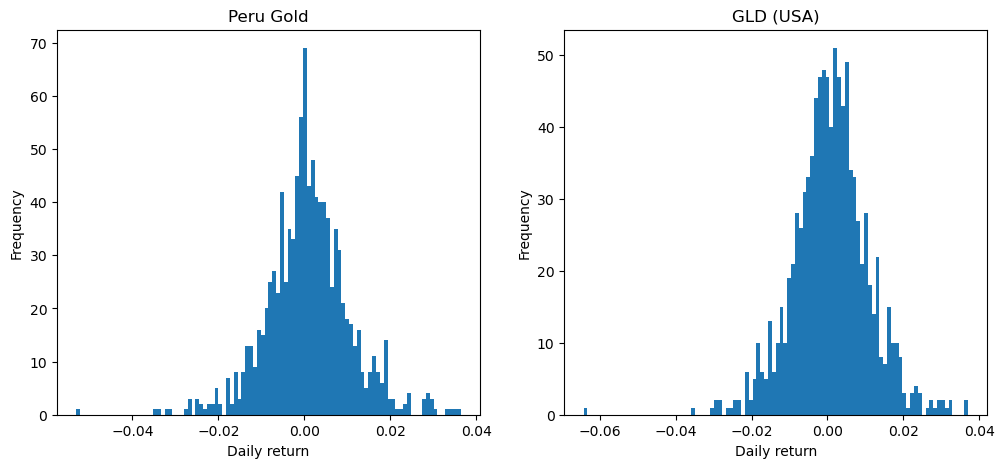

In [61]:
# 3. Plot two histograms side by side with the same binning

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Peru gold returns (drop missing returns)
axes[0].hist(peru_gold['ret'].dropna(), bins=100)
axes[0].set_title("Peru Gold")
axes[0].set_xlabel("Daily return")
axes[0].set_ylabel("Frequency")

# GLD returns (drop missing returns)
axes[1].hist(usa_gld['ret'].dropna(), bins=100)
axes[1].set_title("GLD (USA)")
axes[1].set_xlabel("Daily return")
axes[1].set_ylabel("Frequency")

plt.show()

## 4) Relationships

### Exercise 4.1 — FX changes vs market returns (Peru + USA)

Use:
- Peru interbank FX (daily % change)
- SPY returns (broad US market benchmark)

**Tasks**
1. Build interbank FX daily returns from the Peru FX series.
2. Build SPY daily returns from `usa`.
3. Merge on date.
4. Scatter plot (x = SPY ret, y = FX ret).
5. Compute correlation and write 2–3 sentences interpreting the sign/magnitude.

In [62]:
# 1. Build interbank FX daily returns from the Peru FX series

# Build Peru interbank FX daily returns
peru_fx_ret = peru_fx[['fx_interbank_buy']].copy()

# Compute daily FX percentage change
peru_fx_ret['fx_ret'] = peru_fx_ret['fx_interbank_buy'].pct_change()
peru_fx_ret.head()

C:\Users\User\AppData\Local\Temp\ipykernel_8872\2911578271.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  peru_fx_ret['fx_ret'] = peru_fx_ret['fx_interbank_buy'].pct_change()


,fx_interbank_buy,fx_ret
date,,
2022-01-03,3.983667,NaN
2022-01-04,3.959500,-0.006066
2022-01-05,3.952000,-0.001894
2022-01-06,3.967167,0.003838
2022-01-07,3.945167,-0.005546


In [63]:
# 2. Build SPY daily returns from `usa`

# Filter SPY returns from USA data
usa_spy = usa[usa['ticker'] == 'SPY'][['date', 'ret']]

# Sort by date and set date as index
usa_spy = usa_spy.sort_values('date').set_index('date')
usa_spy.head()

,ret
date,
2022-01-03,NaN
2022-01-04,-0.000335
2022-01-05,-0.019202
2022-01-06,-0.000939
2022-01-07,-0.003954


In [64]:
# 3. Merge on date

fx_spy = peru_fx_ret[['fx_ret']].join(usa_spy, how='inner')

# Rename columns 
fx_spy = fx_spy.rename(columns={'ret': 'spy_ret'})
fx_spy.head()

,fx_ret,spy_ret
date,,
2022-01-03,NaN,NaN
2022-01-04,-0.006066,-0.000335
2022-01-05,-0.001894,-0.019202
2022-01-06,0.003838,-0.000939
2022-01-07,-0.005546,-0.003954


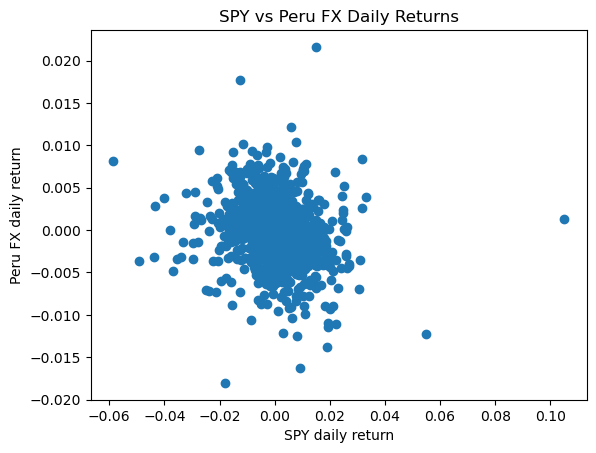

In [65]:
# 4. Scatter plot (x = SPY ret, y = FX ret).

plt.scatter(fx_spy['spy_ret'], fx_spy['fx_ret'])

plt.xlabel("SPY daily return")
plt.ylabel("Peru FX daily return")
plt.title("SPY vs Peru FX Daily Returns")

plt.show()

In [66]:
# 5. Compute correlation and write 2–3 sentences interpreting the sign/magnitude
correlation = fx_spy['spy_ret'].corr(fx_spy['fx_ret'])
correlation

np.float64(-0.17198671856961367)

The correlation between SPY returns and Peru FX returns is negative and relatively small in magnitude (−0.17). This indicates a weak inverse relationship, where positive U.S. equity returns tend to be associated with slight Peru FX depreciations. However, the low absolute value suggests that the relationship is weak and not economically strong at the daily frequency.

## 5) References 

- BCRP Statistical Series (Daily): exchange rates and commodities series catalog.
- BCRPData API (CSV endpoint) for downloading series.
- yfinance: Python wrapper that fetches historical market data from Yahoo Finance.

## 2) Online Data Sources 

### Exercise 2.1 — Inspect the BCRPData API URL (requests)
You are already downloading from BCRPData. Now you will **inspect** what is being requested.

**Tasks**
1. Recreate the API URL string used to download the Peru series.
2. Print it.
3. Download the CSV text using `http_get_text` and display the first 10 lines.
4. Explain (in a markdown cell) what each part of the URL means.

In [67]:
from pathlib import Path
import time
import requests

def fetch_text_with_session(url: str, timeout: int = 30, tries: int = 3) -> str:
    """Fetch raw text using a requests.Session (cookies) + browser-like headers."""
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        ),
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.9,es;q=0.8",
        "Referer": "https://estadisticas.bcrp.gob.pe/",
        "Connection": "keep-alive",
        "Cache-Control": "no-cache",
        "Pragma": "no-cache",
    }

    s = requests.Session()

    # Warm-up request to get cookies (can help with WAF/403)
    try:
        s.get("https://estadisticas.bcrp.gob.pe/", headers=headers, timeout=timeout)
    except Exception:
        pass

    last = None
    for k in range(tries):
        try:
            r = s.get(url, headers=headers, timeout=timeout)
            if r.status_code == 403:
                last = requests.HTTPError(f"403 Forbidden for url: {url}")
                time.sleep(1.5 * (k + 1))
                continue
            r.raise_for_status()
            return r.text
        except Exception as e:
            last = e
            time.sleep(1.5 * (k + 1))

    raise last


SERIES = ["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]

START_D = "2022-01-01"
END_D   = "2025-12-18"
LANG    = "ing"

# 1) Recreate the API URL string used to download the Peru series
codes = "-".join(SERIES)
url_multi = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{START_D}/{END_D}/{LANG}"

print("BCRPData URL (multi-series):")
print(url_multi)

# 2-3) Try to download raw CSV text and show first 10 lines
txt = None
raw_source = None

try:
    txt = fetch_text_with_session(url_multi, timeout=30, tries=3)
    raw_source = "server (multi-series)"
except Exception as e:
    print(f"[BCRP] Multi-series request failed: {type(e).__name__}: {e}")

# Fallback: try only ONE series (often allowed even if multi is blocked)
if txt is None:
    one = SERIES[0]
    url_one = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{one}/csv/{START_D}/{END_D}/{LANG}"
    print("\nBCRPData URL (single-series fallback):")
    print(url_one)
    try:
        txt = fetch_text_with_session(url_one, timeout=30, tries=3)
        raw_source = f"server (single-series: {one})"
    except Exception as e:
        print(f"[BCRP] Single-series request failed: {type(e).__name__}: {e}")

if txt is not None:
    # Replace <br> HTML tags with newline characters (some responses use HTML breaks)
    txt_clean = (txt.replace("<br />", "\n").replace("<br/>", "\n").replace("<br>", "\n"))

    lines = txt_clean.splitlines()
    print(f"\nFirst 10 lines of the response ({raw_source}):")
    for i, line in enumerate(lines[:10], start=1):
        print(f"{i:02d}: {line}")

else:
    # Last-resort fallback: reconstruct "CSV-like" lines from your cached dataframes
    # NOTE: this is NOT the raw server response; it's reconstructed from local data.
    print("\n[BCRP] Could not fetch raw text due to 403. Reconstructing lines from local data (NOT raw server response).")

    # Try to use peru_w if it exists; else use peru if it exists.
    if "peru_w" in globals() and hasattr(peru_w, "head"):
        preview = peru_w.head(10).to_csv(index=False)
        rec_lines = preview.splitlines()[:10]
        print("\nFirst 10 lines (reconstructed from peru_w):")
        for i, line in enumerate(rec_lines, start=1):
            print(f"{i:02d}: {line}")
    elif "peru" in globals() and hasattr(peru, "head"):
        preview = peru.head(10).to_csv(index=False)
        rec_lines = preview.splitlines()[:10]
        print("\nFirst 10 lines (reconstructed from peru):")
        for i, line in enumerate(rec_lines, start=1):
            print(f"{i:02d}: {line}")
    else:
        print("No local dataframes found (peru/peru_w). Run the download cells first.")


BCRPData URL (multi-series):
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/csv/2022-01-01/2025-12-18/ing

First 10 lines of the response (server (multi-series)):
01: D&iacute;a/Mes/A&ntilde;o,"Tipo de cambio - TC Interbancario (S/ por US$) - Compra","Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Compra","Cotizaciones internacionales - Cobre (Londres, cUS$ por libras)","Cotizaciones internacionales - Oro (Londres, US$ por onzas troy)"
02: "03.Jan.22","3.98366666666667","3.987","439.621724973844","1820.1"
03: "04.Jan.22","3.9595","3.963","438.170229389944","1811.4"
04: "05.Jan.22","3.952","3.953","443.522619355577","1826.25"
05: "06.Jan.22","3.96716666666667","3.967","433.86110187524","1789.35"
06: "07.Jan.22","3.94516666666667","3.948","436.129063725084","1792.6"
07: "10.Jan.22","3.92766666666667","3.925","438.397025574929","1794.2"
08: "11.Jan.22","3.91633333333333","3.919","438.260947863938","1806.8"
09: "12.Jan.22","3.89233

### Exercise 2.2 — Build a clean wide table (Peru finance data)
Turn long BCRP data into a clean table.

**Tasks**
1. Use `peru_w` (already wide).
2. Rename columns to short names:
   - `fx_interbank`, `fx_sbs`, `gold`, `copper`
   (Hint: inspect column names first.)
3. Create daily percentage changes for FX and commodities.
4. Drop rows where all four returns are missing.

In [68]:
from io import StringIO

# Read CSV text into DataFrame 
peru_raw = pd.read_csv(StringIO(txt_clean))
peru_raw.columns

Index(['D&iacute;a/Mes/A&ntilde;o',
       'Tipo de cambio - TC Interbancario (S/ por US$) - Compra',
       'Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Compra',
       'Cotizaciones internacionales - Cobre (Londres, cUS$ por libras)',
       'Cotizaciones internacionales - Oro (Londres, US$ por onzas troy)'],
      dtype='object')

In [69]:
# 1. Use `peru_w` (already wide)

month = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr",
    "May": "May", "Jun": "Jun", "Jul": "Jul", "Ago": "Aug",
    "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov",
    "Dic": "Dec"
}

# Rename date column
peru_raw = peru_raw.rename(columns={"D&iacute;a/Mes/A&ntilde;o": "date"})

# Fix month names in date string
peru_raw["date"] = peru_raw["date"].replace(month, regex=True)

# Convert date to datetime
peru_raw["date"] = pd.to_datetime(peru_raw["date"],format="%d.%b.%y",errors="coerce")

# Convert remaining columns to numeric
cols = peru_raw.columns.drop("date")
peru_raw[cols] = peru_raw[cols].apply(pd.to_numeric, errors="coerce")

# Sort by date and set date as index
peru_raw = peru_raw.sort_values("date").set_index("date")
peru_raw.head()

,Tipo de cambio - TC Interbancario (S/ por US$) - Compra,Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Compra,"Cotizaciones internacionales - Cobre (Londres, cUS$ por libras)","Cotizaciones internacionales - Oro (Londres, US$ por onzas troy)"
date,,,,
2022-01-03,3.983667,3.987,439.621725,1820.10
2022-01-04,3.959500,3.963,438.170229,1811.40
2022-01-05,3.952000,3.953,443.522619,1826.25
2022-01-06,3.967167,3.967,433.861102,1789.35
2022-01-07,3.945167,3.948,436.129064,1792.60


In [70]:
# 2. Rename columns to short names:- `fx_interbank`, `fx_sbs`, `gold`, `copper`

peru_raw = peru_raw.rename(columns={
    "Tipo de cambio - TC Interbancario (S/ por US$) - Compra": "fx_interbank",
    "Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Compra": "fx_sbs",
    "Cotizaciones internacionales - Cobre (Londres, cUS$ por libras)": "copper",
    "Cotizaciones internacionales - Oro (Londres, US$ por onzas troy)": "gold"
})

# Rename DataFrame
peru_w = peru_raw
peru_w.head()

,fx_interbank,fx_sbs,copper,gold
date,,,,
2022-01-03,3.983667,3.987,439.621725,1820.10
2022-01-04,3.959500,3.963,438.170229,1811.40
2022-01-05,3.952000,3.953,443.522619,1826.25
2022-01-06,3.967167,3.967,433.861102,1789.35
2022-01-07,3.945167,3.948,436.129064,1792.60


In [71]:
# 3. Create daily percentage changes for FX and commodities.
# 4. Drop rows where all four returns are missing.

# Compute daily percentage changes and drop mising values
peru_ret = peru_w.pct_change().dropna(how="all")
peru_ret.head()

C:\Users\User\AppData\Local\Temp\ipykernel_8872\3720389350.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  peru_ret = peru_w.pct_change().dropna(how="all")


,fx_interbank,fx_sbs,copper,gold
date,,,,
2022-01-04,-0.006066,-0.006020,-0.003302,-0.004780
2022-01-05,-0.001894,-0.002523,0.012215,0.008198
2022-01-06,0.003838,0.003542,-0.021784,-0.020205
2022-01-07,-0.005546,-0.004790,0.005227,0.001816
2022-01-10,-0.004436,-0.005826,0.005200,0.000893


## 3) Matplotlib: Constructing the Plot 

### Exercise 3.1 
Create a single figure with 2 subplots:
- Top: Peru FX spread (SBS - interbank)
- Bottom: USA SPY close price

**Tasks**
1. Build the Peru FX spread series from `peru_w`.
2. Build SPY close series from `usa_w`.
3. Use `plt.subplots(nrows=2, ncols=1, sharex=True)`.
4. Add titles, axis labels, and use `fig.tight_layout()`.

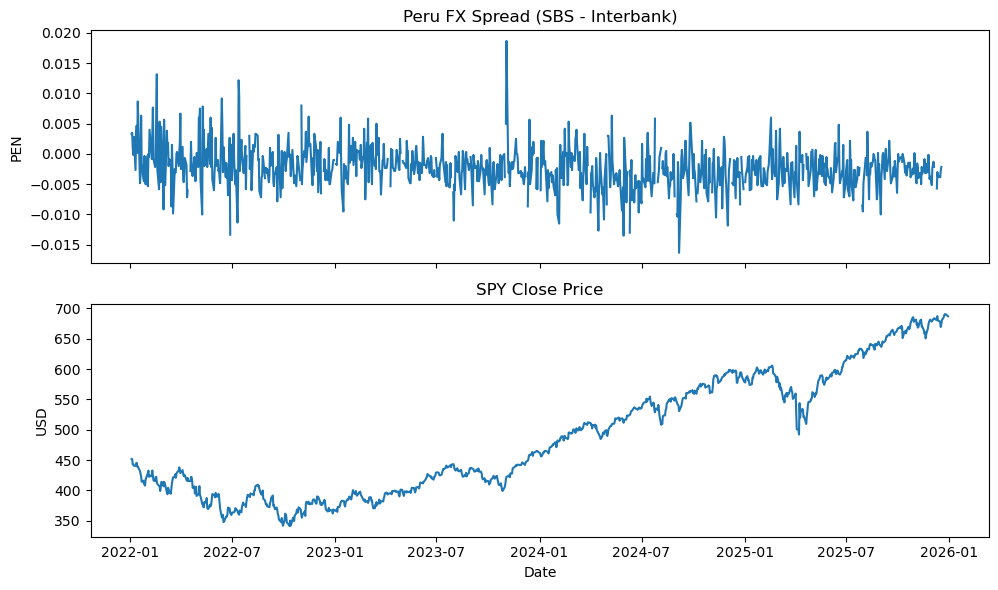

In [72]:
# 1. Build Peru FX spread: SBS - Interbank
peru_fx_spread = peru_w["fx_sbs"] - peru_w["fx_interbank"]

# 2. Build SPY close price series
spy_close = usa_raw["SPY"]

# 3. Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

# Top plot: Peru FX spread
axes[0].plot(peru_fx_spread.index, peru_fx_spread)
axes[0].set_title("Peru FX Spread (SBS - Interbank)")
axes[0].set_ylabel("PEN")

# Bottom plot: SPY close price
axes[1].plot(spy_close.index, spy_close)
axes[1].set_title("SPY Close Price")
axes[1].set_ylabel("USD")
axes[1].set_xlabel("Date")

# 4. Adjust layout
fig.tight_layout()

plt.show()

### Exercise 3.2 — Annotations (mark a key event on a series)
Annotate the largest absolute daily SPY return.

**Tasks**
1. Find the date with the largest `abs(ret)` for SPY.
2. Plot SPY returns over time.
3. Add an annotation at the extreme point (arrow + text).

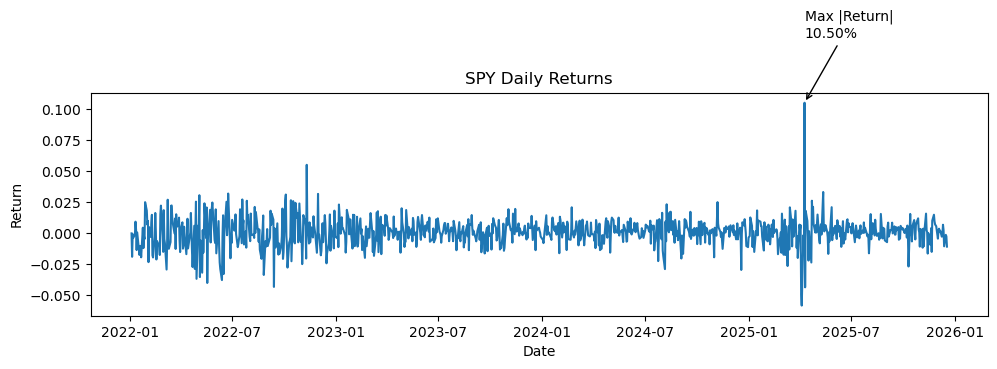

In [73]:
# 1. Find the date with the largest absolute daily return for SPY
spy_returns = usa_spy["ret"]
extreme_date = spy_returns.abs().idxmax()
extreme_value = spy_returns.loc[extreme_date]

# 2. Plot SPY returns over time
plt.figure(figsize=(10, 4))
plt.plot(spy_returns.index, spy_returns)
plt.title("SPY Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")

# 3. Annotate the extreme point
plt.annotate(
    f"Max |Return|\n{extreme_value:.2%}",
    xy=(extreme_date, extreme_value),
    xytext=(extreme_date, extreme_value * 1.5),
    arrowprops=dict(arrowstyle="->")
)

plt.tight_layout()
plt.show()

### Exercise 3.3 — Saving the figure
Save one of your figures to disk.

**Tasks**
1. Create a folder `figures/` if it does not exist.
2. Save the subplot figure as `figures/lecture4II_fx_spy.png` with dpi=150.
3. Confirm the file exists.

In [74]:
import os

# Create figures folder if it does not exist
os.makedirs("figures", exist_ok=True)

# Recreate the subplot figure (from Exercise 3.1)
peru_fx_spread = peru_w["fx_sbs"] - peru_w["fx_interbank"]
spy_close = usa_raw["SPY"]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

axes[0].plot(peru_fx_spread.index, peru_fx_spread)
axes[0].set_title("Peru FX Spread (SBS - Interbank)")
axes[0].set_ylabel("PEN")

axes[1].plot(spy_close.index, spy_close)
axes[1].set_title("SPY Close Price")
axes[1].set_ylabel("USD")
axes[1].set_xlabel("Date")

fig.tight_layout()

# Save figure
file_path = "figures/lecture4II_fx_spy.png"
fig.savefig(file_path, dpi=150)
plt.close(fig)

# Confirm the file exists
os.path.exists(file_path)


True

## 4) Statistics 
### Exercise 4.1 — Summary statistics table (returns)
Build a clean table of return moments.

**Tasks**
1. Create a wide daily returns table for SPY, TLT, GLD.
2. Compute: mean, std, skewness, kurtosis.
3. Present results as a DataFrame with tickers as rows.

In [75]:
# 1. Create wide daily returns table
usa_ret = usa[['date', 'ticker', 'ret']].copy()
usa_ret = usa_ret.rename(columns={"ret": "return"}) 

returns_wide = (
    usa_ret.pivot(index="date", columns="ticker", values="return")
    .sort_index()
)

# 2. Compute summary statistics
summary_stats = pd.DataFrame({
    "Mean": returns_wide.mean(),
    "Std": returns_wide.std(),
    "Skewness": returns_wide.skew(),
    "Kurtosis": returns_wide.kurt()
})

# 3. Display results
summary_stats

,Mean,Std,Skewness,Kurtosis
ticker,,,,
GLD,0.000920,0.010029,-0.196324,2.401211
SPY,0.000408,0.011408,0.370137,9.031124
TLT,-0.000446,0.010441,0.014346,0.372478


### Exercise 4.2 — 
Run a simple regression of GLD returns on SPY returns:

\[
GLD_t = \alpha + \beta\,SPY_t + \varepsilon_t
\]

**Tasks**
1. Build aligned return vectors (drop missing).
2. Compute \alpha and \beta using the closed-form OLS formulas.
3. Plot the scatter and fitted line.
4. Interpret \beta in 2–3 sentences.

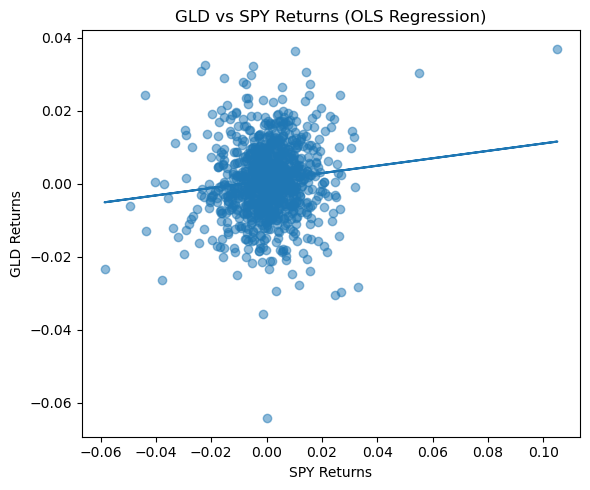

(np.float64(0.0008789945468910876), np.float64(0.10180354086179275))

In [76]:
# 1. Build aligned return vectors (drop missing)
reg_data = returns_wide[['SPY', 'GLD']].dropna()
spy_ret = reg_data["SPY"]
gld_ret = reg_data["GLD"]

# 2. Closed-form OLS estimates
beta_hat = np.cov(spy_ret, gld_ret, ddof=0)[0, 1] / np.var(spy_ret, ddof=0)
alpha_hat = gld_ret.mean() - beta_hat * spy_ret.mean()

# Fitted values
gld_fitted = alpha_hat + beta_hat * spy_ret

# 3. Scatter plot and fitted line
plt.figure(figsize=(6, 5))
plt.scatter(spy_ret, gld_ret, alpha=0.5)
plt.plot(spy_ret, gld_fitted)
plt.xlabel("SPY Returns")
plt.ylabel("GLD Returns")
plt.title("GLD vs SPY Returns (OLS Regression)")
plt.tight_layout()
plt.show()

alpha_hat, beta_hat

## 5) Risk and Uncertainty 

### Exercise 5.1 — Historical VaR (95%) for a 60/40 portfolio
Portfolio:
- 60% SPY
- 40% TLT

**Tasks**
1. Create a wide returns table for SPY and TLT.
2. Compute portfolio daily returns.
3. Compute 1-day 95% Historical VaR (the 5th percentile of returns).
4. Compute 1-day 95% CVaR (average return below the 5th percentile).

In [77]:
# 1. Create wide returns table for SPY and TLT
returns_60_40 = returns_wide[['SPY', 'TLT']].dropna()

# 2. Compute portfolio daily returns
portfolio_ret = 0.6 * returns_60_40["SPY"] + 0.4 * returns_60_40["TLT"]

# 3. Compute 1-day 95% Historical VaR (5th percentile)
var_95 = portfolio_ret.quantile(0.05)

# 4. Compute 1-day 95% CVaR (average return below the VaR)
cvar_95 = portfolio_ret[portfolio_ret <= var_95].mean()

var_95, cvar_95

(np.float64(-0.013703131391403734), np.float64(-0.018592606080486598))

## 6) References

- BCRPData API (CSV endpoint): BCRP statistical series API for downloading time series
- BCRP series catalog: codes for FX (interbank/SBS) and commodity reference prices
- yfinance: Python wrapper to access historical market data from Yahoo Finance